In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

In [3]:
train_df = pd.read_csv('../data/decision_tree/train.csv')
val_df = pd.read_csv('../data/decision_tree/val.csv')
test_df = pd.read_csv('../data/decision_tree/test.csv')

In [4]:
Xtrain = train_df[train_df.columns[:-1]]
ytrain = train_df[train_df.columns[-1]]
Xval = val_df[val_df.columns[:-1]]
yval = val_df[val_df.columns[-1]]
Xtest = test_df[test_df.columns[:-1]]
ytest = test_df[test_df.columns[-1]]

In [5]:
Xtest.shape

(116157, 54)

In [5]:
def predictions(root,X):

    X = X.values
    ypred = []
    m = X.shape[0]
    for i in range(m):
        x = X[i]
        curr = root
        while curr and (curr.left or curr.right or len(curr.children) > 0):

            Xj = curr.attribute
            #print(Xj)
            if curr.cont:
                if x[Xj] <= curr.value:
                    curr = curr.left
                else:
                    curr = curr.right
            else:
                curr = curr.children[x[Xj]]

        if curr:
            ypred.append(curr.label)
        else:
            ypred.append(-1)

    return np.array(ypred)

In [5]:
def entropy(y):
    # Computes H(y) for the dataset provided
    unique_val = np.unique(y)
    count = []
    for v in unique_val:
        count.append(np.count_nonzero(y == v))
    
    count = np.array(count)
    count = count / np.sum(count)
    
    return np.sum(-count * np.log2(count))

class Node:
    
    def __init__(self,attribute = None, label = None):
        self.attribute = attribute              # Attribute (index) on which the node is splitted.
        self.children = {}                      # List of children where the individual elements are Nodes.
        self.label = label                      # The majority class at that attribute.
        self.left = None                        # Left child in case of splitting a continuous attribute. Contains values of Xj lesser than the median.
        self.right = None                       # Right child in case of splitting a continuous attriute. Contains values of Xj greater than the median.
        self.cont = False                       # True if the attribute is continuous
        self.value = None                       # Value of the attribute which is used for making the split.
        self.parent = None                      # The parent pointer for the nodes.
        self.isLeaf = False                     # Boolean variable indicating whether the node is leaf or not.
        self.id = None                          # Unique id assigned to each node
        self.inf_gain = None                    # The information_gain at this node

    
    def __lt__(self, other):
        return self.inf_gain > other.inf_gain

def CreateLeaf(label):
    n = Node(label = label)
    return n

class DecisionTree:
    
    def __init__(self):
        
        self.root = None
        self.cont = None
        self.disc = None
        self.acc_test = []
        self.acc_val = []
        self.acc_train = []
    
    def ChooseBestAttrToSplit(self,X,y):
        
        cols = X.shape[1]
        inf_gain = -np.inf
        bestattr = -1
        h_y = entropy(y)
        for i in range(cols):
            h_y_x = 0
            if np.count_nonzero(self.cont == i):
                med = np.median(X[:,i])
                
                mask1 = (X[:,i] <= med)
                h_y_x += np.mean(mask1)*entropy(y[mask1])
    
                mask2 = (X[:,i] > med)
                h_y_x += np.mean(mask2)*entropy(y[mask2])
            
            else:
                # Discrete Feature
                values = np.unique(X[:,i])
                for v in values:
                    mask = (X[:,i] == v)
                    h_y_x +=  np.mean(mask)*entropy(y[mask])
                
            diff = h_y - h_y_x
            if diff > inf_gain:
                inf_gain = diff
                bestattr = i
        return bestattr,inf_gain
            
    def GrowTree(self,X,y):
        
        if np.unique(y).shape[0] == 1:
            #print("Here")
            return CreateLeaf(label = y[0])

        Xj,inf_gain = self.ChooseBestAttrToSplit(X,y)
        #print(Xj,height)
        sepCol = X[:,Xj]
        parent = Node(attribute=Xj)
        parent.inf_gain = inf_gain
        
        if np.count_nonzero(self.cont == Xj):
            
            # Splitting for Continuous features
            
            sep = np.median(sepCol)
            mask1 = (X[:,Xj] <= sep)
            mask2 = (X[:,Xj] > sep)
            if np.sum(mask1) > 0 and np.sum(mask2) > 0:
                
                subX = X[mask1]
                subY = y[mask1]
                child = self.GrowTree(subX,subY,height + 1)
                parent.left = child
                child.parent = parent
                
                subX = X[mask2]
                subY = y[mask2]

                child = self.GrowTree(subX,subY)
                parent.right = child
                child.parent = parent

                parent.value = sep
                parent.cont = True
                
            else:
                # Termination condition where there are non-empty left and right splits.
                val = np.bincount(y)
                parent.label = np.argmax(val)
            
        else:
            
            # Splitting for discrete features.
            
            unique = np.unique(sepCol)
            for i in unique:
                mask = (X[:,Xj] == i)
                subX = X[mask]
                subY = y[mask]
                child = self.GrowTree(subX,subY)
                child.parent = parent
                parent.children[i] = child
                
        return parent
    
    def iter_GrowTree(self,X,y,Xtest,ytest,Xval,yval):
        
        Xstack = []
        ystack = []
        childStack = []
        root = Node()
        childStack.append(root)
        Xstack.append(X)
        ystack.append(y)
        nodes = 0
        
        while len(childStack) > 0:

            curr = childStack.pop()
            
            currX = Xstack.pop()
            curry = ystack.pop()
            
            if np.unique(curry).shape[0] == 1:
                curr.label = curry[0]
                curr.isLeaf = True

            else:
                Xj,inf_gain = self.ChooseBestAttrToSplit(currX,curry)
                curr.inf_gain = inf_gain
                curr.attribute = Xj
                curr.label = np.argmax(np.bincount(curry))
                sepCol = currX[:,Xj]

                if np.count_nonzero(self.cont == Xj):

                    sep = np.median(sepCol)
                    mask1 = (currX[:,Xj] <= sep)
                    mask2 = (currX[:,Xj] > sep)
                    if np.sum(mask1) > 0 and np.sum(mask2) > 0:

                        subX = currX[mask2]
                        subY = curry[mask2]

                        child = Node()
                        curr.right = child
                        child.parent = curr

                        childStack.append(child)
                        Xstack.append(subX)
                        ystack.append(subY)

                        subX = currX[mask1]
                        subY = curry[mask1]
                        child = Node()
                        curr.left = child
                        child.parent = curr

                        childStack.append(child)
                        Xstack.append(subX)
                        ystack.append(subY)

                        curr.value = sep
                        curr.cont = True
                    else:
                        val = np.bincount(y)
                        curr.label = np.argmax(val)
                else:
                    unique = np.unique(sepCol)
                    for i in unique:
                        mask = (currX[:,Xj] == i)
                        subX = currX[mask]
                        subY = curry[mask]
                        child = Node()
                        curr.children[i] = child
                        child.parent = curr
                        childStack.append(child)
                        Xstack.append(subX)
                        ystack.append(subY)
                
            #print(nodes)
            #if nodes % 1000 == 0:
                #ypred = predictions(root,Xtrain)
                #acc = np.mean(ypred == y)
                #print("Train:",acc)
                #self.acc_train.append(acc)
                #ypred = predictions(root,Xtest)
                #acc = np.mean(ypred == ytest.values)
                #print("Test:",acc)
                #self.acc_test.append(acc)
                #ypred = predictions(root,Xval)
                #acc = np.mean(ypred == yval.values)
                #print("Val:",acc)
                #self.acc_val.append(acc)
                #print(len(childStack),len(ystack))
            curr.id = nodes
            nodes += 1
            
        return root
            
            
    def fit(self,X,y):
        # X and y are pandas dataframes with the column labels stating whether a feature is continuous or discrete
        
        #Segreagating continuous and discrete features and storing their indices
        
        cols = X.columns
        cont = []
        for i in range(len(cols)):
            if cols[i][-8:] == "Discrete":
                continue
            else:
                cont.append(i)
        self.cont = np.array(cont)
        self.root = self.GrowTree(X.values,y.values,0)
        
    def iter_fit(self,X,y,Xtest,ytest,Xval,yval):
        # Function for fitting to the iterative version of train. Also used for generating the data for the plot.
        cols = X.columns
        cont = []
        for i in range(len(cols)):
            if cols[i][-8:] == "Discrete":
                continue
            else:
                cont.append(i)
        self.cont = np.array(cont)
        self.root = self.iter_GrowTree(X.values,y.values,Xtest,ytest,Xval,yval)
        
        
    def predict(self,X):
        # Function for predicting the labels for the instances. Returns an np array corresponding of size X.shape[0]
        X = X.values
        ypred = []
        m = X.shape[0]
        for i in range(m):
            x = X[i]
            curr = self.root
            while curr and (curr.left or curr.right or len(curr.children) > 0):

                Xj = curr.attribute
                #print(Xj)
                if curr.cont:
                    if x[Xj] <= curr.value:
                        curr = curr.left
                    else:
                        curr = curr.right
                else:
                    curr = curr.children[x[Xj]]
            
            if curr:
                ypred.append(curr.label)
            else:
                ypred.append(-1)
                
        return np.array(ypred)
    
    def score(self,X,y):
        # Returns the accuracy score for the predictions made
        ypreds = self.predict(X)
        return np.mean(ypreds == y.values)

In [54]:
# Code for training the dtr using the recursive function
start = time.time()
dtr_rec = DecisionTree()
dtr_rec.fit(Xtrain,ytrain)
end = time.time()
print("Training Time:",end-start)

Training Time: 226.14084672927856


In [15]:
# Code for training dtr using the iterative function
start = time.time()
dtr_iter = DecisionTree()
dtr_iter.iter_fit(Xtrain,ytrain,Xtest,ytest,Xval,yval)
end = time.time()
print("Training Time:",end-start)

Training Time: 205.93845176696777


In [13]:
val_score = dtr_iter.score(Xval,yval)
val_score

0.9018378891228878

In [9]:
dtr_iter.score(Xtrain,ytrain)

0.9999938599453535

In [10]:
dtr_iter.score(Xtest,ytest)

0.902252985183846

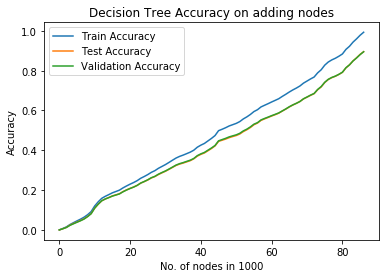

In [89]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots()
ax.plot([i for i in range(len(dtr_iter.acc_train))],dtr_iter.acc_train,label = "Train Accuracy")
ax.plot([i for i in range(len(dtr_iter.acc_test))],dtr_iter.acc_test,label = "Test Accuracy")
ax.plot([i for i in range(len(dtr_iter.acc_val))],dtr_iter.acc_val,label = "Validation Accuracy")
ax.legend(loc = 'best')
ax.set_xlabel("No. of nodes in 1000")
ax.set_ylabel("Accuracy")
ax.set_title("Decision Tree Accuracy on adding nodes")
fig.savefig('plot_dtr.png',dpi = 200)
plt.show()

In [19]:
def count(tree):
    # Function for counting the number of nodes.
    if tree and tree.children == None and tree.left == None and tree.right == None:
        return 1
    else:
        nodes = 1
        for child in tree.children.keys():
            nodes += count(tree.children[child])
        if tree.left:
            nodes += count(tree.left)
        if tree.right:
            nodes += count(tree.right)
    return nodes

#count(dtr_rec.root)

In [47]:
train_prune = []
val_prune = []
test_prune = []

### Pruning Decision Trees

In [18]:
def createNodeList(root,nodeError):
    # This function fills the dictionary whose keys are the ids of the nodes and the values are intialized to 0.
    nodeError[root.id] = 0
    if root.cont:
        createNodeList(root.left,nodeError)
        createNodeList(root.right,nodeError)
    else:
        for child in root.children.keys():
            createNodeList(root.children[child],nodeError)

def countLeaves(root):
    # Function for counting the number of leaves in the tree
    if root.isLeaf:
        return 1
    else:
        n = 0
        if root.cont:
            n += countLeaves(root.left)
            n += countLeaves(root.right)
        else:
            for child in root.children.keys():
                n += countLeaves(root.children[child])
        return n

def isTwig(root):
    # A Twig is a node whose all children are leaves.
    if not root.isLeaf:
        if root.cont:
            if (root.left.isLeaf) and (root.right.isLeaf):
                return True
            return False
        else:
            for child in root.children.keys():
                if not root.children[child].isLeaf:
                    return False
            return True
    else:
        return False

def classifyValidationDataInstance(root,x,y,nodeError):
    # Each validation instance is passed down the tree and error is checked for each node if the predicted class is the majority label assigned to each node.
    if root.label != y:
        nodeError[root.id] += 1
    if not root.isLeaf:
        if root.cont:
            if x[root.attribute] <= root.value:
                child = root.left
            else:
                child = root.right
        else:
            child = root.children[x[root.attribute]]
        classifyValidationDataInstance(child,x,y,nodeError)
    return 

def classifyValidationData(root,Xval,yval):
    # Errors computed for all the instances in the validation data.
    Xval = Xval.values
    yval = yval.values
    nodeError = {}
    createNodeList(root,nodeError)
    m = Xval.shape[0]
    for i in range(m):
        x = Xval[i]
        y = yval[i]
        classifyValidationDataInstance(root,x,y,nodeError)
    return nodeError

def collectTwigsByErrorCount(root,nodeError,heap):
    # For all the twigs, we calculate the error if we prune the children of the twigs. We insert the twig into a min-heap and the key for the
    # heap is the difference between the errors of the parent and child.
    if isTwig(root):
        twigErrorIncrease = nodeError[root.id]
        
        if root.cont:
            twigErrorIncrease -= nodeError[root.left.id]
            twigErrorIncrease -= nodeError[root.right.id]
            heap.append((twigErrorIncrease,root))
            #heappush(heap,(twigErrorIncrease,root))
        else:
            for child in root.children.keys():
                twigErrorIncrease -= nodeError[root.children[child].id]
            heap.append((twigErrorIncrease,root))
            #heappush(heap, (twigErrorIncrease,root))
    else:
        if root.cont:
            collectTwigsByErrorCount(root.left,nodeError,heap)
            collectTwigsByErrorCount(root.right,nodeError,heap)
        else:
            for child in root.children.keys():
                collectTwigsByErrorCount(root.children[child],nodeError,heap)
    return heap

def pruneByClassification(root,Xval,yval):
    # We prune out nodes until the key of the nodes(twigs) in the heap don't become >= 0. 
    nodeError = classifyValidationData(root,Xval,yval)
    twigHeap = collectTwigsByErrorCount(root,nodeError,[])
    totalLeaves = countLeaves(root)
    
    c = 0
    
    while True:
        
        twig = min(twigHeap)
        twigHeap.remove(twig)
        #twig = heappop(twigHeap)
        
        #if mn == twig:
        #    print("Not true")
        
        if twig[0] > 0:
            break
        
        par = twig[1].parent
        if twig[1].cont:
            totalLeaves -= 1
            
            twig[1].left = None
            twig[1].right = None
            twig[1].isLeaf = True
            twig[1].inf_gain = 0
            
        else:
            totalLeaves -= len(twig[1].children)-1
            twig[1].children = {}
            twig[1].isLeaf = True
            twig[1].inf_gain = 0
            
        if isTwig(par):
            twigErrorIncrease = nodeError[par.id]
            if par.cont:
                twigErrorIncrease -= nodeError[par.left.id]
                twigErrorIncrease -= nodeError[par.right.id]
            else:
                for child in par.children.keys():
                    twigErrorIncrease -= nodeError[par.children[child].id]
            
            twigHeap.append((twigErrorIncrease,par))
        #if c % 200 == 0:
        #    val_prune.append(dtr_iter.score(Xval,yval))
        #    train_prune.append(dtr_iter.score(Xtrain,ytrain))
        #    test_prune.append(dtr_iter.score(Xtest,ytest))
        c += 1
    return

In [19]:
temp = dtr_iter.root
pruneByClassification(temp,Xval,yval)

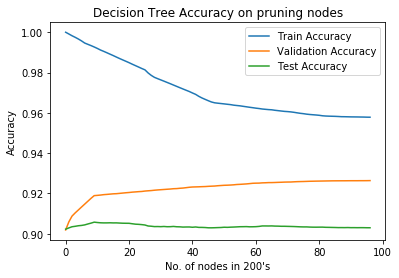

In [54]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots()
ax.plot([i for i in range(len(train_prune))],train_prune,label = "Train Accuracy")
ax.plot([i for i in range(len(val_prune))],val_prune,label = "Validation Accuracy")
ax.plot([i for i in range(len(test_prune))],test_prune,label = "Test Accuracy")
ax.legend(loc = 'best')
ax.set_xlabel("No. of nodes in 200's")
ax.set_ylabel("Accuracy")
ax.set_title("Decision Tree Accuracy on pruning nodes")
fig.savefig('../output/q1/plot_dtr_prune.png',dpi = 200)
plt.show()

In [51]:
len(train_prune)

97

In [20]:
count(dtr_iter.root)

NameError: name 'count' is not defined

In [21]:
dtr_iter.score(Xval,yval)

0.9264269336649249

In [13]:
dtr_iter.score(Xtest,ytest)

0.9029244901297382

In [14]:
dtr_iter.score(Xval,yval)

0.9264269336649249

In [57]:
dtr_iter.score(Xtrain,ytrain)

0.9577625640868204

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid, GridSearchCV, PredefinedSplit

param_grid = {'n_estimators': [i for i in range(50,500,100)],'max_features':[i for i in np.arange(0.1,1,0.2)],'min_samples_split':[i for i in range(2,12,2)]}

In [5]:
param_grid

{'n_estimators': [50, 150, 250, 350, 450],
 'max_features': [0.1,
  0.30000000000000004,
  0.5000000000000001,
  0.7000000000000001,
  0.9000000000000001],
 'min_samples_split': [2, 4, 6, 8, 10]}

In [5]:
def oob_scorer(estimator, X, y):
    return estimator.oob_score_

In [10]:
rfc = RandomForestClassifier(oob_score = True, criterion = 'entropy')
from sklearn.externals.joblib import parallel_backend

gs = GridSearchCV(estimator=rfc,param_grid=param_grid,scoring=oob_scorer,cv = PredefinedSplit([-1]*(Xtrain.shape[0]-1) + [0]),n_jobs=1, verbose = 10)
with parallel_backend('threading'):
    gs.fit(Xtrain, ytrain)
#best_score = 0
#best_grid = None
#start = time.time()
#for g in pg:
#    print(g)
#    rfc.set_params(**g)
#    rfc.fit(Xtrain,ytrain)
#    end = time.time()
#    if rfc.oob_score_ > best_score:
#        best_score = rfc.oob_score_
#        best_grid = g
#    print(rfc.oob_score)
#    print("Time:",end-start)
# gs.fit(Xtrain,ytrain)

Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV] max_features=0.3, min_samples_split=4, n_estimators=150 .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=0.3, min_samples_split=4, n_estimators=150, score=0.957, total= 3.0min
[CV] max_features=0.3, min_samples_split=4, n_estimators=250 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s


[CV]  max_features=0.3, min_samples_split=4, n_estimators=250, score=0.958, total= 4.9min
[CV] max_features=0.3, min_samples_split=4, n_estimators=350 .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.0min remaining:    0.0s


[CV]  max_features=0.3, min_samples_split=4, n_estimators=350, score=0.958, total= 7.0min
[CV] max_features=0.3, min_samples_split=6, n_estimators=150 .........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 15.0min remaining:    0.0s


[CV]  max_features=0.3, min_samples_split=6, n_estimators=150, score=0.956, total= 3.0min
[CV] max_features=0.3, min_samples_split=6, n_estimators=250 .........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 18.0min remaining:    0.0s


[CV]  max_features=0.3, min_samples_split=6, n_estimators=250, score=0.956, total= 5.0min
[CV] max_features=0.3, min_samples_split=6, n_estimators=350 .........


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 23.0min remaining:    0.0s


[CV]  max_features=0.3, min_samples_split=6, n_estimators=350, score=0.957, total= 7.1min
[CV] max_features=0.3, min_samples_split=8, n_estimators=150 .........


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 30.1min remaining:    0.0s


[CV]  max_features=0.3, min_samples_split=8, n_estimators=150, score=0.954, total= 3.0min
[CV] max_features=0.3, min_samples_split=8, n_estimators=250 .........


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 33.1min remaining:    0.0s


[CV]  max_features=0.3, min_samples_split=8, n_estimators=250, score=0.954, total= 5.0min
[CV] max_features=0.3, min_samples_split=8, n_estimators=350 .........


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 38.1min remaining:    0.0s


[CV]  max_features=0.3, min_samples_split=8, n_estimators=350, score=0.955, total= 6.6min
[CV] max_features=0.5, min_samples_split=4, n_estimators=150 .........


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 44.6min remaining:    0.0s


[CV]  max_features=0.5, min_samples_split=4, n_estimators=150, score=0.961, total= 4.6min
[CV] max_features=0.5, min_samples_split=4, n_estimators=250 .........
[CV]  max_features=0.5, min_samples_split=4, n_estimators=250, score=0.962, total= 8.9min
[CV] max_features=0.5, min_samples_split=4, n_estimators=350 .........
[CV]  max_features=0.5, min_samples_split=4, n_estimators=350, score=0.962, total=12.2min
[CV] max_features=0.5, min_samples_split=6, n_estimators=150 .........
[CV]  max_features=0.5, min_samples_split=6, n_estimators=150, score=0.960, total= 4.7min
[CV] max_features=0.5, min_samples_split=6, n_estimators=250 .........
[CV]  max_features=0.5, min_samples_split=6, n_estimators=250, score=0.960, total= 7.5min
[CV] max_features=0.5, min_samples_split=6, n_estimators=350 .........
[CV]  max_features=0.5, min_samples_split=6, n_estimators=350, score=0.961, total=10.8min
[CV] max_features=0.5, min_samples_split=8, n_estimators=150 .........
[CV]  max_features=0.5, min_sample

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 194.4min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1,  0])),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=Fals

In [11]:
gs.best_params_

{'max_features': 0.7, 'min_samples_split': 4, 'n_estimators': 350}

In [15]:
param_grid

{'n_estimators': [50, 150, 250, 350, 450],
 'max_features': [0.1,
  0.30000000000000004,
  0.5000000000000001,
  0.7000000000000001,
  0.9000000000000001],
 'min_samples_split': [2, 4, 6, 8, 10]}

In [7]:
rfc = RandomForestClassifier(oob_score = True, criterion = 'entropy')
from sklearn.externals.joblib import parallel_backend

gs1 = GridSearchCV(estimator=rfc,param_grid=param_grid,scoring=oob_scorer,cv = PredefinedSplit([-1]*(Xtrain.shape[0]-1) + [0]),n_jobs=1, verbose = 10)
gs1.fit(Xtrain, ytrain)
#best_score = 0

/home/parm_khakhar/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 125 candidates, totalling 125 fits
[CV] max_features=0.1, min_samples_split=2, n_estimators=50 ..........
[CV]  max_features=0.1, min_samples_split=2, n_estimators=50, score=0.936, total=  32.6s
[CV] max_features=0.1, min_samples_split=2, n_estimators=150 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.6s remaining:    0.0s


[CV]  max_features=0.1, min_samples_split=2, n_estimators=150, score=0.943, total= 1.7min
[CV] max_features=0.1, min_samples_split=2, n_estimators=250 .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


[CV]  max_features=0.1, min_samples_split=2, n_estimators=250, score=0.944, total= 2.7min
[CV] max_features=0.1, min_samples_split=2, n_estimators=350 .........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.0min remaining:    0.0s


[CV]  max_features=0.1, min_samples_split=2, n_estimators=350, score=0.944, total= 3.9min
[CV] max_features=0.1, min_samples_split=2, n_estimators=450 .........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.8min remaining:    0.0s


[CV]  max_features=0.1, min_samples_split=2, n_estimators=450, score=0.944, total= 5.2min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 14.0min remaining:    0.0s


[CV] max_features=0.1, min_samples_split=4, n_estimators=50 ..........
[CV]  max_features=0.1, min_samples_split=4, n_estimators=50, score=0.934, total=  35.7s
[CV] max_features=0.1, min_samples_split=4, n_estimators=150 .........


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 14.7min remaining:    0.0s


[CV]  max_features=0.1, min_samples_split=4, n_estimators=150, score=0.940, total= 1.8min
[CV] max_features=0.1, min_samples_split=4, n_estimators=250 .........


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 16.4min remaining:    0.0s


[CV]  max_features=0.1, min_samples_split=4, n_estimators=250, score=0.943, total= 2.8min
[CV] max_features=0.1, min_samples_split=4, n_estimators=350 .........


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 19.2min remaining:    0.0s


[CV]  max_features=0.1, min_samples_split=4, n_estimators=350, score=0.942, total= 4.0min
[CV] max_features=0.1, min_samples_split=4, n_estimators=450 .........


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 23.2min remaining:    0.0s


[CV]  max_features=0.1, min_samples_split=4, n_estimators=450, score=0.942, total= 4.9min
[CV] max_features=0.1, min_samples_split=6, n_estimators=50 ..........
[CV]  max_features=0.1, min_samples_split=6, n_estimators=50, score=0.933, total=  31.8s
[CV] max_features=0.1, min_samples_split=6, n_estimators=150 .........
[CV]  max_features=0.1, min_samples_split=6, n_estimators=150, score=0.938, total= 1.6min
[CV] max_features=0.1, min_samples_split=6, n_estimators=250 .........
[CV]  max_features=0.1, min_samples_split=6, n_estimators=250, score=0.939, total= 2.9min
[CV] max_features=0.1, min_samples_split=6, n_estimators=350 .........
[CV]  max_features=0.1, min_samples_split=6, n_estimators=350, score=0.940, total= 4.1min
[CV] max_features=0.1, min_samples_split=6, n_estimators=450 .........
[CV]  max_features=0.1, min_samples_split=6, n_estimators=450, score=0.940, total= 4.6min
[CV] max_features=0.1, min_samples_split=8, n_estimators=50 ..........
[CV]  max_features=0.1, min_samples

[CV]  max_features=0.5000000000000001, min_samples_split=4, n_estimators=150, score=0.964, total= 4.1min
[CV] max_features=0.5000000000000001, min_samples_split=4, n_estimators=250 
[CV]  max_features=0.5000000000000001, min_samples_split=4, n_estimators=250, score=0.965, total= 6.8min
[CV] max_features=0.5000000000000001, min_samples_split=4, n_estimators=350 
[CV]  max_features=0.5000000000000001, min_samples_split=4, n_estimators=350, score=0.965, total= 9.4min
[CV] max_features=0.5000000000000001, min_samples_split=4, n_estimators=450 
[CV]  max_features=0.5000000000000001, min_samples_split=4, n_estimators=450, score=0.965, total=12.1min
[CV] max_features=0.5000000000000001, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5000000000000001, min_samples_split=6, n_estimators=50, score=0.960, total= 1.3min
[CV] max_features=0.5000000000000001, min_samples_split=6, n_estimators=150 
[CV]  max_features=0.5000000000000001, min_samples_split=6, n_estimators=150, score=0.963, t

[CV]  max_features=0.9000000000000001, min_samples_split=2, n_estimators=250, score=0.965, total=11.0min
[CV] max_features=0.9000000000000001, min_samples_split=2, n_estimators=350 
[CV]  max_features=0.9000000000000001, min_samples_split=2, n_estimators=350, score=0.966, total=15.3min
[CV] max_features=0.9000000000000001, min_samples_split=2, n_estimators=450 
[CV]  max_features=0.9000000000000001, min_samples_split=2, n_estimators=450, score=0.966, total=19.8min
[CV] max_features=0.9000000000000001, min_samples_split=4, n_estimators=50 
[CV]  max_features=0.9000000000000001, min_samples_split=4, n_estimators=50, score=0.962, total= 2.2min
[CV] max_features=0.9000000000000001, min_samples_split=4, n_estimators=150 
[CV]  max_features=0.9000000000000001, min_samples_split=4, n_estimators=150, score=0.965, total= 6.6min
[CV] max_features=0.9000000000000001, min_samples_split=4, n_estimators=250 
[CV]  max_features=0.9000000000000001, min_samples_split=4, n_estimators=250, score=0.965, t

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 858.0min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1,  0])),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_l...
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=

In [8]:
gs1.best_params_

{'max_features': 0.7000000000000001,
 'min_samples_split': 2,
 'n_estimators': 450}

In [9]:
gs1.best_score_

0.9663124867604665

In [6]:
rfc_best = RandomForestClassifier(n_estimators=450, min_samples_split=2,max_features=0.7,criterion = 'entropy',oob_score = True)

In [11]:
rfc_best.fit(Xtrain,ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=0.7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=450,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [12]:
rfc_best.oob_score_

0.9661068983513953

In [13]:
rfc_best.score(Xtrain,ytrain)

1.0

In [14]:
rfc_best.score(Xval,yval)

0.9662754174243676

In [15]:
rfc_best.score(Xtest,ytest)

0.9670876486135145

### Parameter Sensitivity Analysis

In [8]:
n_estimators = 450
min_samples_split = 2
max_features = 0.7

val_acc = []
test_acc = []
estimator = []
start = time.time()

for i in range(50,500,100):
    rf = RandomForestClassifier(n_estimators = i, min_samples_split=2, max_features=0.7,criterion = 'entropy')
    rf.fit(Xtrain,ytrain)
    val_acc.append(rf.score(Xval,yval))
    test_acc.append(rf.score(Xtest,ytest))
    estimator.append(i)
    print(i)
    end = time.time()
    print("Time:",end-start)

50
Time: 124.72827792167664
150
Time: 458.59120869636536
250
Time: 1010.5879955291748
350
Time: 1793.8527176380157
450
Time: 3053.6532089710236


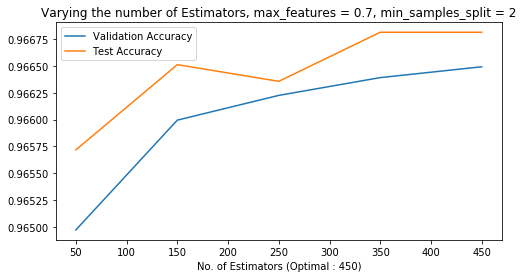

In [9]:
fig,ax = plt.subplots(figsize = (8,4))
ax.plot(estimator,val_acc,label = 'Validation Accuracy')
ax.plot(estimator,test_acc,label = 'Test Accuracy')
ax.set_xlabel("No. of Estimators (Optimal : 450)")
ax.set_title("Varying the number of Estimators, max_features = 0.7, min_samples_split = 2")
ax.legend(loc = 'best')
fig.savefig('../output/q1/estimator.png',dpi = 200)

In [8]:
n_estimators = 450
min_samples_split = 2
max_features = 0.7

val_acc_1 = []
test_acc_1 = []
estimator_1 = []
start = time.time()
for i in range(2,12,2):
    rf = RandomForestClassifier(n_estimators = 450, min_samples_split=i, max_features=0.7,criterion = 'entropy')
    rf.fit(Xtrain,ytrain)
    val_acc_1.append(rf.score(Xval,yval))
    test_acc_1.append(rf.score(Xtest,ytest))
    estimator_1.append(i)
    end = time.time()
    print(i)
    print("Time:",end-start)

2
Time: 1069.6500492095947
4
Time: 2072.1090450286865
6
Time: 3023.8372435569763
8
Time: 3970.0040068626404
10
Time: 4913.718044757843


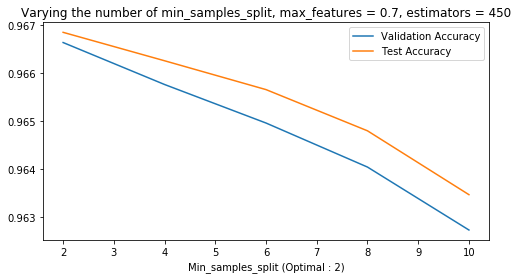

In [9]:
fig,ax = plt.subplots(figsize = (8,4))
ax.plot(estimator_1,val_acc_1,label = 'Validation Accuracy')
ax.plot(estimator_1,test_acc_1,label = 'Test Accuracy')
ax.set_xlabel("Min_samples_split (Optimal : 2)")
ax.set_title("Varying the number of min_samples_split, max_features = 0.7, estimators = 450")
ax.legend(loc = 'best')
fig.savefig('../output/q1/min_samples_split.png',dpi = 200)

In [5]:
n_estimators = 450
min_samples_split = 2
max_features = [0.1,0.3,0.5,0.7,0.9]

val_acc_2 = []
test_acc_2 = []
estimator_2 = []
start = time.time()
for i in max_features:
    rf = RandomForestClassifier(n_estimators = 450, min_samples_split=2, max_features=i,criterion = 'entropy')
    rf.fit(Xtrain,ytrain)
    val_acc_2.append(rf.score(Xval,yval))
    test_acc_2.append(rf.score(Xtest,ytest))
    estimator_2.append(i)
    end = time.time()
    print(i)
    print("Time:",end-start)

0.1
Time: 288.17009568214417
0.3
Time: 779.8311583995819
0.5
Time: 1516.6239280700684
0.7
Time: 2468.8102598190308
0.9
Time: 3653.641505241394


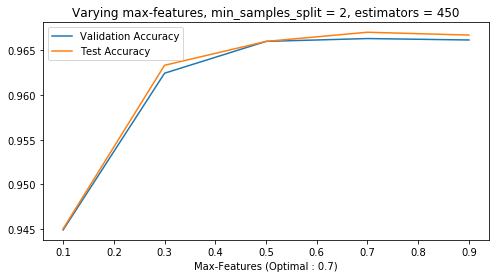

In [7]:
fig,ax = plt.subplots(figsize = (8,4))
ax.plot(estimator_2,val_acc_2,label = 'Validation Accuracy')
ax.plot(estimator_2,test_acc_2,label = 'Test Accuracy')
ax.set_xlabel("Max-Features (Optimal : 0.7)")
ax.set_title("Varying max-features, min_samples_split = 2, estimators = 450")
ax.legend(loc = 'best')
fig.savefig('../output/q1/max_features.png',dpi = 200)